In [ ]:
!pip install mesa==2.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.5/264.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 25

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% ! important; }<style>"))

import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
import random
import time
random.seed(911)

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

from sklearn import metrics
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

In [ ]:
'''
Функция compute_polar принимает объект model, в котором есть список (или иной итерабельный объект) agents.
Каждый агент в этом списке имеет атрибут opinion. Функция собирает все значения мнений в список, суммирует их и возвращает эту сумму.
'''

def compute_polar(model):
    B = 0
    for agent in model.schedule.agents:
        B += agent.opinion
    return B


Функция `compute_polar(model)` вычисляет агрегированное значение мнений всех агентов в модели, что позволяет судить о **степени поляризации** системы.

Обозначим:

- $x_i$ — мнение $i$-го агента;
- $N$ — общее количество агентов;
- $B$ — суммарное мнение в системе.

Тогда вычисление поляризации описывается формулой:

$$
B = \sum_{i=1}^{N} x_i
$$

Интерпретация значения $B$:

- Если $B \approx 0$, то мнения агентов распределены симметрично, и в системе преобладает **согласие** или **умеренность**.
- Если $B \gg 0$, большинство агентов склоняются к положительной крайности (правый полюс).
- Если $B \ll 0$, преобладают отрицательные мнения (левый полюс).

Таким образом, $B$ служит простым **скалярным индикатором степени поляризации** системы в каждый момент времени.


# Построение модели

### Логика агентов и модели

Каждый агент $i$ обладает:

- мнением $x_i \in [-1, 1]$,
- уровнем неопределенности $u_i > 0$.

Диапазон мнения:  
$$
[x_i - u_i,\ x_i + u_i]
$$

#### Условие взаимодействия

Агенты $i$ и $j$ взаимодействуют, если их диапазоны пересекаются:

$$
[x_i - u_i,\ x_i + u_i] \cap [x_j - u_j,\ x_j + u_j] \ne \emptyset
$$

#### Обновление мнений (если $h_{ij} > u$)

$$
x_j \leftarrow x_j + \mu \cdot \left( \frac{h_{ij}}{u_i} - 1 \right) \cdot (x_i - x_j)
$$

$$
u_j \leftarrow u_j + \mu \cdot \left( \frac{h_{ij}}{u_i} - 1 \right) \cdot (u_i - u_j)
$$

Параметр $\mu$ — сила влияния.  
Экстремисты — агенты с минимальной неопределенностью $u \approx 0$ и крайними значениями $x \approx \pm1$.

#### Режимы:

- `pairwise=True`: взаимодействие по одному.
- `pairwise=False`: взаимодействие со всеми.



In [ ]:
class CustomAgent(Agent):
    def __init__(self, agent_id, model, opinion, uncertainty, is_extremist=0):
        # Уникальный идентификатор агента (agent_id),
        # модель, к которой принадлежит агент (model),
        # мнение агента из диапазона [-1, 1] (opinion),
        # степень неуверенности агента (uncertainty),
        # флаг, указывающий, является ли агент экстремистом или нет (is_extremist)
        super().__init__(agent_id, model)

        self.agent_id = agent_id
        self.opinion = opinion
        self.uncertainty = uncertainty
        self.is_extremist = is_extremist

    def get_other_agent(self):
        # Выбор другого агента для взаимодействия, учитывая ограничение на повторное взаимодействие в одном шаге
        other_agent = self.random.choice(self.model.schedule.agents)
        while other_agent.agent_id in self.model.made_step:
            other_agent = self.random.choice(self.model.schedule.agents)
        return other_agent


    def interaction(self, agent_1, agent_2):
    # Рассчёт взаимодействия между двумя агентами и обновление их мнений и степени неуверенности

        # Сначала вычисляется общий охват мнений обоих агентов (h_ij)
        h_ij = min(agent_1.opinion + agent_1.uncertainty, agent_2.opinion + agent_2.uncertainty) - max(agent_1.opinion - agent_1.uncertainty, agent_2.opinion - agent_2.uncertainty)

        # Если общий охват мнений превышает степень неуверенности первого агента
        if h_ij > agent_1.uncertainty:
            # то мнение и неуверенность второго агента обновляются
            agent_2.opinion = agent_2.opinion + self.model.mu * (h_ij / agent_1.uncertainty - 1) * (agent_1.opinion - agent_2.opinion)
            agent_2.uncertainty = agent_2.uncertainty + self.model.mu * (h_ij / agent_1.uncertainty - 1) * (agent_1.uncertainty - agent_2.uncertainty)

            # Далее, ограничивается мнение агента диапазоном [-1, 1],
            agent_2.opinion = max(-1, min(agent_2.opinion, 1))

        # Если общий охват мнений превышает степень неуверенности второго агента
        if h_ij > agent_2.uncertainty:
            # то мнение и неуверенность первого агента обновляются
            agent_1.opinion = agent_1.opinion + self.model.mu * (h_ij / agent_2.uncertainty - 1) * (agent_2.opinion - agent_1.opinion)
            agent_1.uncertainty = agent_1.uncertainty + self.model.mu * (h_ij / agent_2.uncertainty - 1) * (agent_2.uncertainty - agent_1.uncertainty)

            # и также ограничивается мнение агента диапазоном [-1, 1]
            agent_1.opinion = max(-1, min(agent_1.opinion, 1))

    def step(self):
        # Одиночный шаг агента, выполняет взаимодействие с другими агентами
        if self.model.pairwise and self.agent_id not in self.model.made_step:
            # Если модель для парного взаимодействия и агент еще не выполнил шаг
            other_agent = self.get_other_agent()
            if not ((self.opinion + self.uncertainty <= other_agent.opinion - other_agent.uncertainty) or (self.opinion - self.uncertainty >= other_agent.opinion + other_agent.uncertainty)):
                # Если есть пересечение интервалов мнений
                self.interaction(self, other_agent)
                self.model.made_step += [self.agent_id, other_agent.agent_id] # Отметка о выполнении шага


        elif not self.model.pairwise:
            # Для группового взаимодействия - обновление текущего мнения и степени неуверенности агента на основе взаимодействия со всеми остальными агентами
            self.opinion_buf_arr = []
            self.uncertainty_buf_arr = []
            for other_agent in self.model.schedule.agents: # пробегаем по всем агентам
                if self.agent_id != other_agent.agent_id:
                    if not ((self.opinion + self.uncertainty <= other_agent.opinion - other_agent.uncertainty) or (self.opinion - self.uncertainty >= other_agent.opinion + other_agent.uncertainty)):
                        h_ij = min(self.opinion + self.uncertainty, other_agent.opinion + other_agent.uncertainty) - max(self.opinion - self.uncertainty, other_agent.opinion - other_agent.uncertainty)
                        if h_ij > other_agent.uncertainty:
                            opinion_new = self.model.mu * (h_ij / other_agent.uncertainty - 1) * (other_agent.opinion - self.opinion)
                            uncertainty_new = self.model.mu * (h_ij / other_agent.uncertainty - 1) * (other_agent.uncertainty - self.uncertainty)
                            if opinion_new > 1: # возвращаем корректное в рамках модели значение
                                opinion_new = 1
                            elif opinion_new < -1:
                                opinion_new = -1
                            self.opinion_buf_arr.append(opinion_new)
                            self.uncertainty_buf_arr.append(uncertainty_new)
                else:
                    continue
            # новые значения считаем как старый x_j + сумма добавок
            self.model.opinion_list[self.agent_id] = self.opinion + sum(self.opinion_buf_arr)

            # Обновление степени неуверенности (uncertainty) текущего агента.
            self.model.uncertainty_list[self.agent_id] = self.uncertainty + sum(self.uncertainty_buf_arr)

In [ ]:
class CustomModel(Model):
    def __init__(self, uncertainty=0.4, uncertainty_extremist=0.05, mu=0.5, share_extremist=0.2, delta=0, N=1000, pairwise=True):
        super().__init__()
        # Инициализация значения параметров модели
        self.num_agents = N  # Общее количество агентов
        self.uncertainty = uncertainty  # Степень неуверенности обычных агентов
        self.uncertainty_extremist = uncertainty_extremist  # Степень неуверенности экстремистов
        self.mu = mu  # Коэффициент чувствительности к чужому мнению
        self.share_extremist = share_extremist  # Доля экстремистов от общего числа агентов
        self.delta = delta  # Относительная разница между долей положительных и отрицательных экстремистов (-1; 1)
        self.pairwise = pairwise  # Флаг, определяющий режим взаимодействия агентов (парный или групповой)
        #self._steps = 0

        self.opinion_list, self.uncertainty_list = [None for _ in range(N)], [None for _ in range(N)]

        if self.pairwise == False:
            self.mu /= (self.num_agents - 1)


        self.schedule = RandomActivation(self)  # Создаем шедулер, который активирует агентов в случайном порядке

        # Генерируем начальные мнения агентов
        opinion_generated = np.random.uniform(-1, 1, self.num_agents)
        opinion_generated_sorted_indexes = np.argsort(opinion_generated)

        # Вычисление отношения числа положительных экстремистов к отрицательным
        p_pos_div_p_neg = (1 + self.delta) / (1 - self.delta)

        # Вычисление количества отрицательных экстремистов
        N_neg_extremist = int((self.num_agents * self.share_extremist) / (1 + p_pos_div_p_neg))

        # Вычисление количества положительных экстремистов
        N_pos_extremist = int(self.num_agents * self.share_extremist) - N_neg_extremist


        # Получение индексов отрицательных экстремистов в массиве.
        # Элементы с самыми низкими мнениями будут отрицательными экстремистами
        #indexes_neg_extremistr = np.argpartition(opinion_generated, N_neg_extremist)[:N_neg_extremist]
        indexes_neg_extremistr = opinion_generated_sorted_indexes[:N_neg_extremist]

        # Получение индексов положительных экстремистов в массиве.
        # Элементы с самыми высокими мнениями будут положительными экстремистами
        #indexes_pos_extremist = np.argpartition(opinion_generated, -N_pos_extremist)[-N_pos_extremist:]
        indexes_pos_extremist = opinion_generated_sorted_indexes[-N_pos_extremist:]

        # Для режима парного взаимодействия создаем массив, в который будем добавлять агентов, участвующих в парном взаимодействии
        if self.pairwise:
            self.made_step = []

        # Для режима группового взаимодействия создаем списки для пересчитанных значений мнений и степеней неуверенности
        else:
            self.opinion_list = [0 for _ in range(self.num_agents)]
            self.uncertainty_list = [0 for _ in range(self.num_agents)]

        # Инициализируем агентов и добавляем их в шедулер
        for i, opinion in enumerate(opinion_generated):
            if (i not in indexes_neg_extremistr) and (i not in indexes_pos_extremist):
                a = CustomAgent(i, self, opinion, self.uncertainty, is_extremist=0)
                self.schedule.add(a)
            else:
                a = CustomAgent(i, self, opinion, self.uncertainty_extremist, is_extremist=1)
                self.schedule.add(a)

        # Добавляем коллектор данных для сбора информации после каждого шага
        self.datacollector = DataCollector(agent_reporters={"Opinions": "opinion"})

    def step(self):
        # Указываем DataCollector'у собирать данные и выполняем следующий шаг модели
        self.datacollector.collect(self)
        self.schedule.step()
        #self._steps += 1

        # Для режима парного взаимодействия очищаем список made_step после каждого шага
        if self.pairwise:
            self.made_step = []

        # Для режима группового взаимодействия после каждого шага обновляем мнение и степень неуверенности каждого агента,
        # а затем сбрасываем списки для следующего шага
        else:
            for a in self.schedule.agents:
                a.opinion = self.opinion_list[a.agent_id]
                a.uncertainty = self.uncertainty_list[a.agent_id]
            self.opinion_list = [0 for _ in range(self.num_agents)]
            self.uncertainty_list = [0 for _ in range(self.num_agents)]

# Моделирование

## Попарно (pairwise=True)

In [ ]:
model = CustomModel(N=400, uncertainty=0.4, uncertainty_extremist=0.05, mu=0.5, share_extremist=0.2, delta=0, pairwise=True)
for i in range(200):
    model.step()

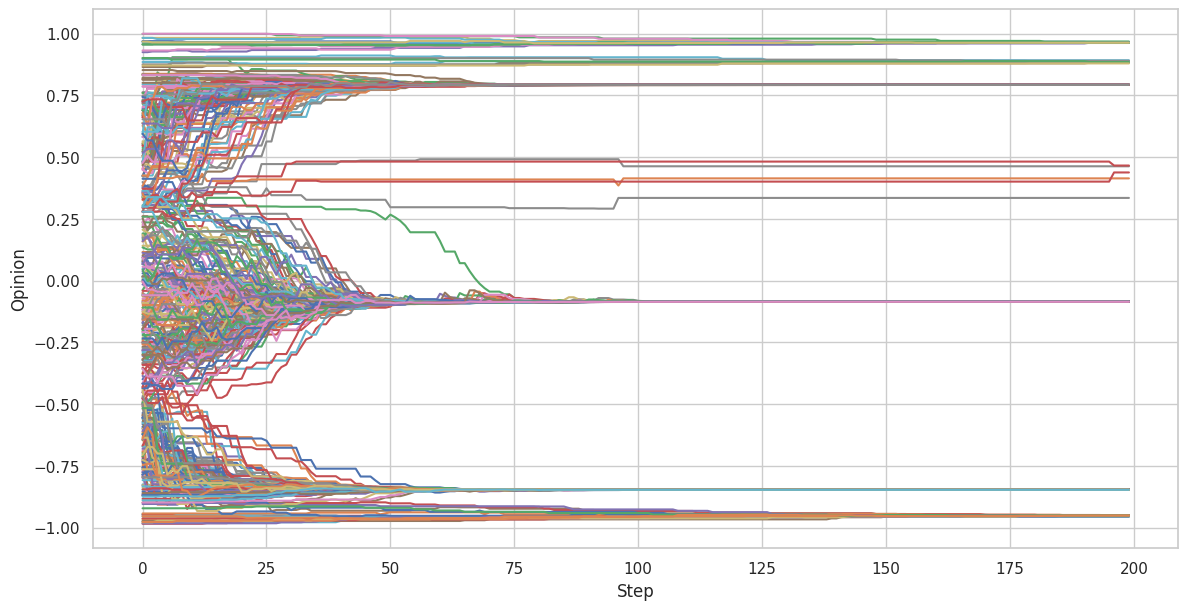

In [ ]:
agent_data = model.datacollector.get_agent_vars_dataframe()

# Транспонируем данные для корректной обработки,
# затем преобразуем фрейм данных в стек формата для построения графика
stacked_data = agent_data.T.stack().T

fig, ax = plt.subplots(figsize=(14, 7))
stacked_data.plot(ax=ax, legend=False)
ax.set_ylabel('Opinion')
plt.show()


Не все агенты поляризовались. Некоторые траектории стабилизировались вблизи $x = 0$, что означает сохранение умеренных мнений.
При относительно низкой доле экстремистов и умеренной неопределенности большая часть агентов сближается, но **не все** переходят к крайним позициям.


In [ ]:
model = CustomModel(N=400, uncertainty=0.8, uncertainty_extremist=0.3, mu=0.5, share_extremist=0.4, delta=0.5, pairwise=True)
for i in range(200):
    model.step()

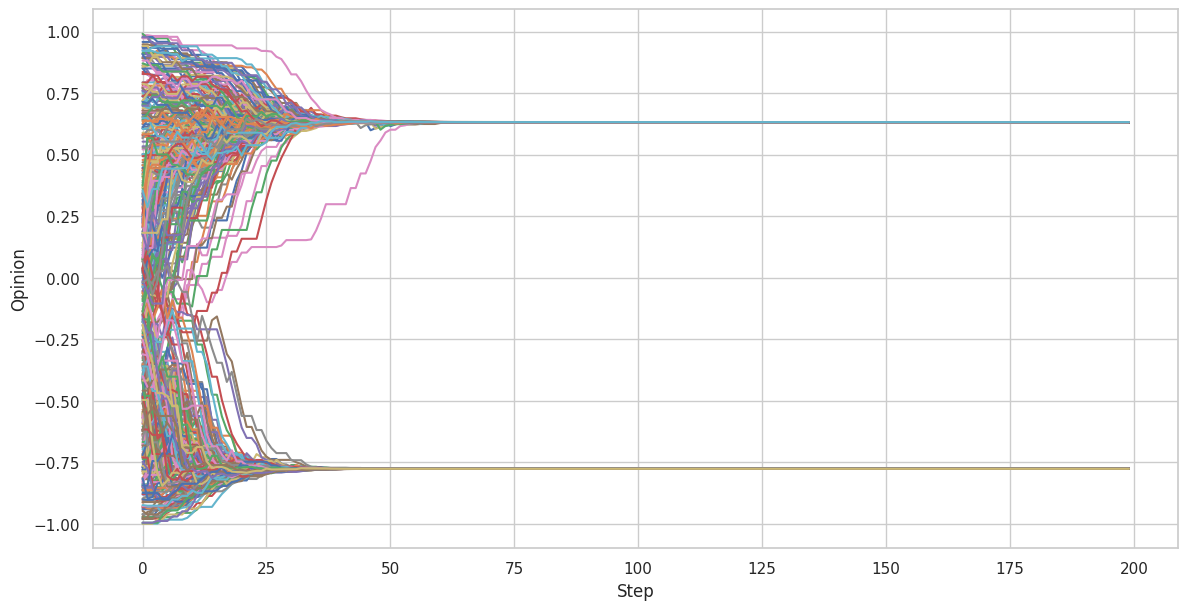

In [ ]:
agent_data = model.datacollector.get_agent_vars_dataframe()

# Транспонируем данные для корректной обработки,
# затем преобразуем фрейм данных в стек формата для построения графика
stacked_data = agent_data.T.stack().T

fig, ax = plt.subplots(figsize=(14, 7))
stacked_data.plot(ax=ax, legend=False)
ax.set_ylabel('Opinion')
plt.show()

In [ ]:
sum(stacked_data.loc[199]>0)

212

Как мы можем наблюдать, в первом случае часть траекторий осталась в середине, то есть остались агенты, мнение которых не поляризировалось. Когда мы изменили параметры (увеличили неуверенность обычных агентов, повысили долю экстремистов и увеличили параметр delta) - ситуация стала иной. Все агенты поляризировались, при этом больше стало агентов с положительным мнением (на это повлиял параметр delta).

Почти все агенты перешли к полярным мнениям — либо $x \approx -1$, либо $x \approx 1$.  
Число агентов с положительным мнением в конце: **227 из 400**.
При высокой неопределенности и увеличенной доле экстремистов (особенно при $\delta > 0$), экстремальные мнения оказываются более «притягательными».  
Асимметрия (через $\delta$) приводит к **перевесу положительного полюса**.

Поляризация усиливается при:
- росте неопределенности у обычных агентов,
- увеличении доли экстремистов $s$,
- асимметрии в распределении экстремистов ($\delta \ne 0$).

## Все со всеми (pairwise=False)

In [ ]:
model = CustomModel(N=400, uncertainty=0.4, uncertainty_extremist=0.05, mu=0.5, share_extremist=0.2, delta=0, pairwise=False)
for i in range(200):
    model.step()

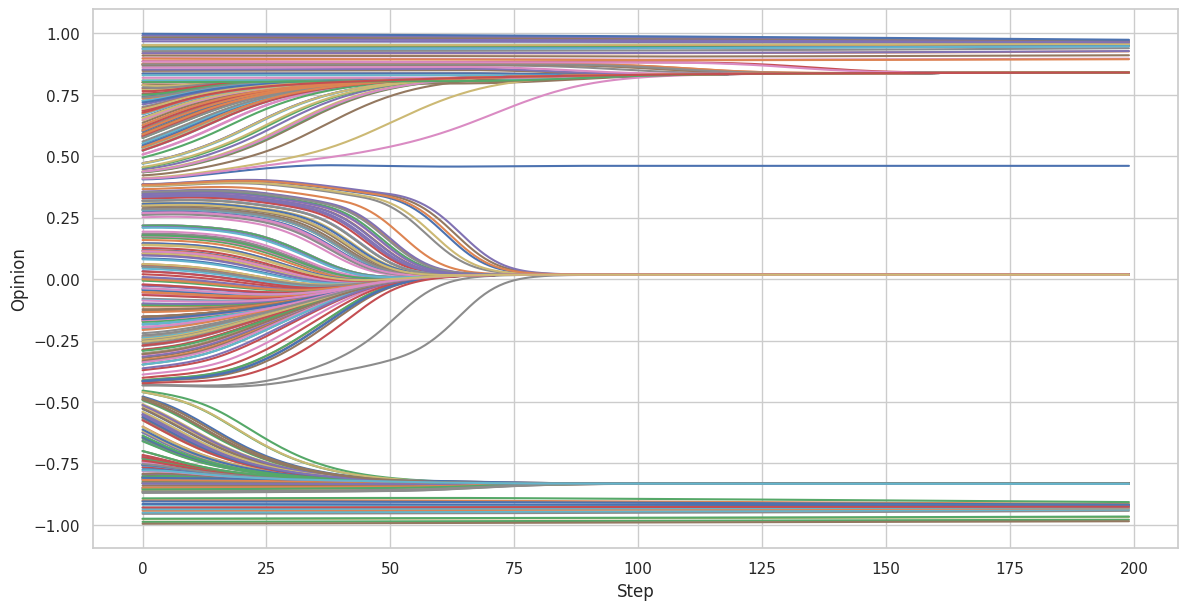

In [ ]:
agent_data = model.datacollector.get_agent_vars_dataframe()

# Транспонируем данные для корректной обработки,
# затем преобразуем фрейм данных в стек формата для построения графика
stacked_data = agent_data.T.stack().T

fig, ax = plt.subplots(figsize=(14, 7))
stacked_data.plot(ax=ax, legend=False)
ax.set_ylabel('Opinion')
plt.show()

Сформировалось несколько устойчивых кластеров мнений.  
Небольшая часть агентов ушла в крайние значения ($x \approx \pm1$), но большая доля сконцентрировалась в промежуточных значениях.
При умеренной неопределенности и симметричной конфигурации экстремистов система **не поляризуется полностью**, а распадается на **несколько кластеров**.


In [ ]:
model = CustomModel(N=400, uncertainty=0.8, uncertainty_extremist=0.3, mu=0.5, share_extremist=0.4, delta=0.5, pairwise=False)
for i in range(200):
    model.step()

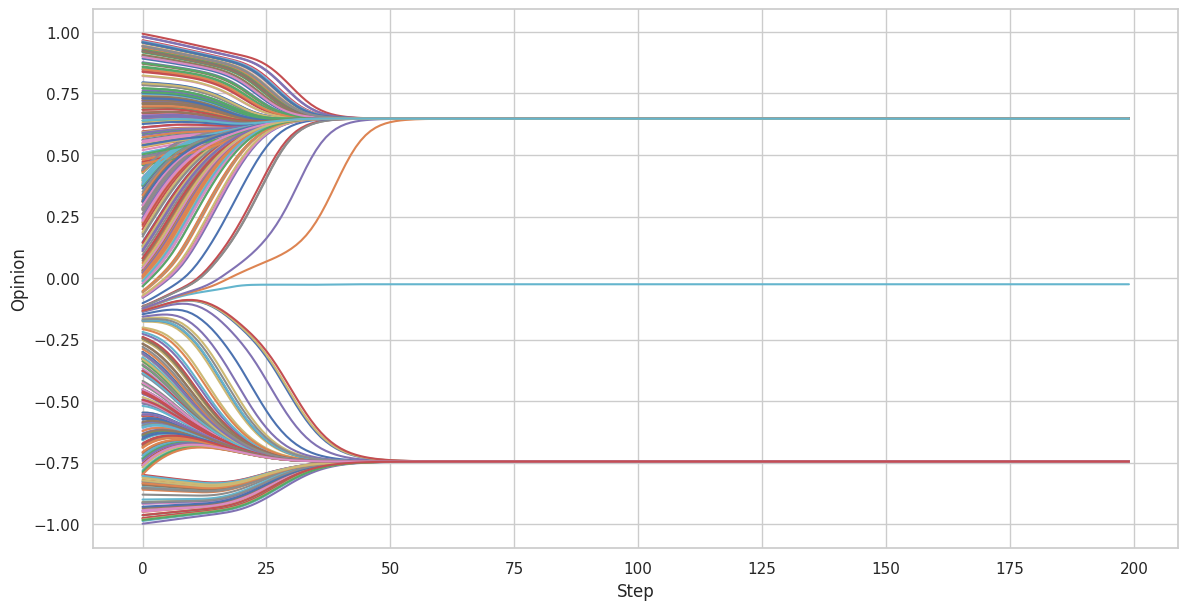

In [ ]:
agent_data = model.datacollector.get_agent_vars_dataframe()

# Транспонируем данные для корректной обработки,
# затем преобразуем фрейм данных в стек формата для построения графика
stacked_data = agent_data.T.stack().T

fig, ax = plt.subplots(figsize=(14, 7))
stacked_data.plot(ax=ax, legend=False)
ax.set_ylabel('Opinion')
plt.show()

Снова мнения поляризировались, однако движение траекторий более плавное.
Почти все агенты сконцентрировались вблизи двух мнений — положительного ($x \approx 0.6$) и отрицательного ($x \approx -0.7$).  
При этом положительный кластер — доминирующий по численности.
Увеличение $u$ и $s$ приводит к **более сильному притяжению к экстремистам**, а несимметричное распределение ($\delta > 0$) вызывает **перекос** в сторону положительного мнения.
В режиме `pairwise=False` каждый агент **влияется всеми одновременно**, что приводит к **более быстрой сходимости** и формированию устойчивых **кластеров мнений**, а не постепенной поляризации, как в `pairwise=True`.

# Сходимость

Наблюдается сходимость


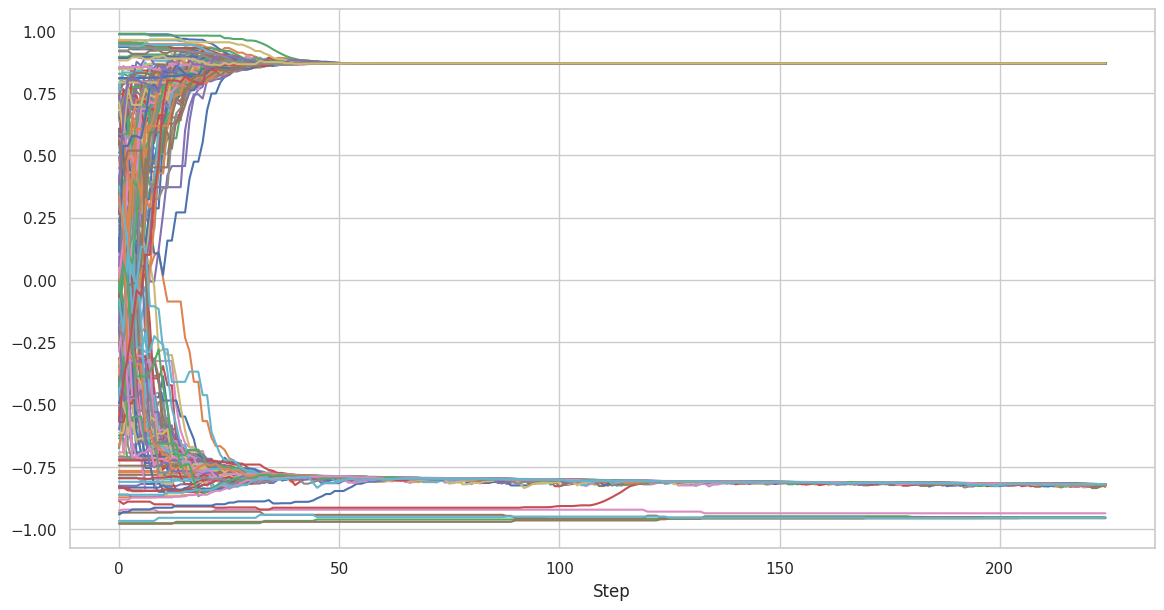

In [ ]:
model = CustomModel(N=200, uncertainty=1.2, uncertainty_extremist=0.1, mu=0.5, share_extremist=0.25, delta=0, pairwise=True)
for i in range(225):
    model.step()

new_df = pd.DataFrame()
agent_data_buf = model.datacollector.get_agent_vars_dataframe()

# Цикл по каждому индексу, полученному из данных агентов
for ag_id in list(agent_data_buf.loc[0].index):
    # Добавление столбца в DataFrame для каждого агента
    new_df = pd.concat((new_df, agent_data_buf.loc[pd.IndexSlice[:, ag_id], :].droplevel(1).copy().rename(
                            columns={'Opinions':str(ag_id)})), axis=1)

# Проверка сходимости модели
if np.all(new_df.iloc[-6:].diff().dropna().apply(lambda x: x < 0.01)) == True: #
    print('Наблюдается сходимость')
else:
    print('Модель не успела сойтись')

agent_data = model.datacollector.get_agent_vars_dataframe()
agent_data.T.stack().T.plot(legend=False, figsize=(14, 7))
ax.set_ylabel('Opinion')
plt.show()

Проверка сходимости модели

Для оценки сходимости модели проверяется, изменилась ли траектория мнений агентов за последние $6$ шагов не более чем на $\varepsilon = 0.01$.

Пусть $x_i^t$ — мнение $i$-го агента на шаге $t$.  
Если:

$$
|x_i^{t} - x_i^{t-1}| < 0.01 \quad \text{для всех } i, \text{на последних 6 шагах}
$$

то считается, что **модель сошлась**.

На графике видно, что большинство траекторий стабилизировались к $\pm1$, что подтверждает сходимость модели.

Метрика доминирования экстремистов

Для количественной оценки «победы» экстремизма используется следующая метрика:

$$
y = \left( \frac{p_+}{N (1 - s)} \right)^2 + \left( \frac{p_-}{N (1 - s)} \right)^2
$$

где:
- $p_+$ — число обычных агентов с мнением $x \ge 1 - c$,
- $p_-$ — число обычных агентов с мнением $x \le -1 + c$,
- $N$ — общее число агентов,
- $s$ — доля экстремистов,
- $c$ — допуск к пограничному значению (например, $c = 0.25$).

Метрика $y$ принимает значения в диапазоне $[0, 2]$:
- $y \approx 0$ — большинство агентов остались умеренными;
- $y \approx 1$ — половина стала радикально положительной, половина — отрицательной;
- $y \approx 2$ — все обычные агенты стали экстремистами по одному из полюсов.

In [ ]:
def convergence_type(model, conv_c = 0.25):
    # определим склонность агента к экстремизму как значение, отличающиеся от 1 по модулю не более чем на 0.25, поскольку при меньшем диапазоне значения сильно различаются со статьёй
    p_plus = 0
    p_minus = 0
    for agent in model.schedule.agents:
        if agent.is_extremist == False:
            if agent.opinion >= 1 - conv_c:
                p_plus += 1
            elif agent.opinion <= -(1 - conv_c):
                p_minus += 1
            else:
                continue
    y = (p_plus / (model.num_agents * (1 - model.share_extremist))) ** 2 + (p_minus / (model.num_agents * (1 - model.share_extremist))) ** 2
    return y

In [ ]:
print(convergence_type(model))

0.5127999999999999


В статье обозначено значение 0,49 (при таких параметрах), у нас 0,5, победа!!!

# ML модель

Датасет собирается крайне долго(в районе 20 минут). По моделям будем использовать простые линейные модели + проверим бустинги, так как они всё же на табличных данных доминируют любую модель.

## Попарно (pairwise=True)

В качестве целевой переменной используется **метрика поляризации** $y$, определяемая как:

$$
y = \left( \frac{p_+}{N (1 - s)} \right)^2 + \left( \frac{p_-}{N (1 - s)} \right)^2
$$

где:
- $p_+$ — число обычных агентов с мнением $x_i \ge 1 - \varepsilon$;
- $p_-$ — с мнением $x_i \le -1 + \varepsilon$;
- $s$ — доля экстремистов;
- $N$ — общее число агентов;
- $\varepsilon$ — допуск (например, $0.25$).

---

1. Для всех комбинаций параметров $(u, u_e, \mu, s, \delta)$ запускается модель.
2. Проверяется, достигнута ли **сходимость**:
   $$
   |x_i^t - x_i^{t-1}| < \varepsilon \quad \text{на последних 6 шагах}
   $$
3. Если модель сошлась, вычисляется значение $y$.
4. Параметры и соответствующее значение $y$ сохраняются в таблицу `train_df`.

In [ ]:
train_df = pd.DataFrame(columns=['uncertainty', 'uncertainty_extremist', 'mu', 'share_extremist', 'delta', 'y'])
share_extremist_lst = [0.2, 0.3, 0.4]
uncertainty_lst = [0.5, 0.8, 1]
uncertainty_extremist_lst = [0.05, 0.1, 0.2]
delta_lst = [0, 0.5, -0.5]
mu_lst = [0.5, 0.7, 0.3]

lists = [uncertainty_lst, uncertainty_extremist_lst, mu_lst, share_extremist_lst, delta_lst]
prod_list = itertools.product(*lists)

In [ ]:
def convergence_check(model, eps=0.005):
    idx = pd.IndexSlice
    new_df = pd.DataFrame()
    opinion_data_buf = model.datacollector.get_agent_vars_dataframe()
    for ag_id in list(opinion_data_buf.loc[0].index):
        new_df = pd.concat((new_df,
                            opinion_data_buf.loc[idx[-15:, ag_id], :].droplevel(1).copy().rename(
                                columns={'Opinions':str(ag_id)})), axis=1)
    if np.all(new_df.iloc[-6:].diff().dropna().apply(lambda x: x < eps)) == True:
        return True

In [ ]:
for element in prod_list:
    uncertainty, uncertainty_extremist, mu, share_extremist, delta = element
    model_test = CustomModel(uncertainty=uncertainty, uncertainty_extremist=uncertainty_extremist, mu=mu, share_extremist=share_extremist, delta=delta, N=200)
    for i in tqdm(range(200)):
        model_test.step()
    if convergence_check(model_test) == True:
        y = convergence_type(model_test)
        d = {'uncertainty': uncertainty, 'uncertainty_extremist': uncertainty_extremist, 'mu': mu, 'share_extremist': share_extremist, 'delta': delta, 'y': y}
        train_df = pd.concat([train_df, pd.DataFrame([d])], ignore_index=True)

100%|██████████| 200/200 [00:06<00:00, 33.16it/s]


In [ ]:
X = train_df.drop(columns=['y'])
y = train_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=911)

In [ ]:
def calculate_metrics(y_train, y_train_pred, y_test, y_test_pred):
    print("Train RMSE = %.3f" % metrics.mean_squared_error(y_train, y_train_pred, squared=False))
    print("Train MAPE = %.3f" % metrics.mean_absolute_percentage_error(y_train, y_train_pred))
    print("Train R^2 = %.3f" % metrics.r2_score(np.array(y_train), y_train_pred))
    print("Test RMSE = %.3f" % mean_squared_error(y_test, y_test_pred, squared=False))
    print("Test MAPE = %.3f" % metrics.mean_absolute_percentage_error(y_test, y_test_pred))
    print("Test R^2 = %.3f" % metrics.r2_score(np.array(y_test), y_test_pred))

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def calculate_metrics(y_train, y_pred_train, y_test, y_pred_test):
    print("🏋️ METRICS ON TRAINING DATA:")
    print("MSE:", mean_squared_error(y_train, y_pred_train))
    print("MAE:", mean_absolute_error(y_train, y_pred_train))
    print("R² :", r2_score(y_train, y_pred_train))
    print()

    print("🧪 METRICS ON TEST DATA:")
    print("MSE:", mean_squared_error(y_test, y_pred_test))
    print("MAE:", mean_absolute_error(y_test, y_pred_test))
    print("R² :", r2_score(y_test, y_pred_test))


In [ ]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

predictions_on_train_data = linear_regression.predict(X_train)
predictions_on_test_data = linear_regression.predict(X_test)

calculate_metrics(y_train, predictions_on_train_data,
                y_test, predictions_on_test_data)

🏋️ METRICS ON TRAINING DATA:
MSE: 0.014761561357659186
MAE: 0.10123157867946934
R² : 0.49031067878700796

🧪 METRICS ON TEST DATA:
MSE: 0.010546947641749262
MAE: 0.08205386287746508
R² : 0.5810407752313157


In [ ]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

train_data_predictions = ridge_model.predict(X_train)
test_data_predictions = ridge_model.predict(X_test)

calculate_metrics(y_train, train_data_predictions,
                  y_test, test_data_predictions)

🏋️ METRICS ON TRAINING DATA:
MSE: 0.0164579132234025
MAE: 0.10766697167896938
R² : 0.43173879671841575

🧪 METRICS ON TEST DATA:
MSE: 0.01331380391827582
MAE: 0.09627412518722364
R² : 0.47113220262483635


In [ ]:
random_forest = RandomForestRegressor(n_estimators=500)
random_forest.fit(X_train, y_train)

predictions_on_train_data = random_forest.predict(X_train)
predictions_on_test_data = random_forest.predict(X_test)

calculate_metrics(y_train, predictions_on_train_data,
                  y_test, predictions_on_test_data)

🏋️ METRICS ON TRAINING DATA:
MSE: 0.0014866420321160807
MAE: 0.028418332284198624
R² : 0.9486690093360081

🧪 METRICS ON TEST DATA:
MSE: 0.014626818930745387
MAE: 0.0762369686386459
R² : 0.4189749557682797


In [ ]:
Gradient_boost = GradientBoostingRegressor(n_estimators=500)
Gradient_boost.fit(X_train, y_train)

predictions_on_train_data = Gradient_boost.predict(X_train)
predictions_on_test_data = Gradient_boost.predict(X_test)

calculate_metrics(y_train, predictions_on_train_data,
                  y_test, predictions_on_test_data)

🏋️ METRICS ON TRAINING DATA:
MSE: 0.002930269368573873
MAE: 0.041341115827191355
R² : 0.8988232362923649

🧪 METRICS ON TEST DATA:
MSE: 0.0156971651103845
MAE: 0.08797515960289574
R² : 0.3764573079247798


### Деревья лучше справляются с задачей, однако и линейные алгоритмы тоже себя неплохо показали.

## Все со всеми (pairwise=False)

Особенность режима `pairwise=False`

В отличие от парного взаимодействия, здесь каждый агент на каждом шаге получает агрегированное влияние **от всех остальных агентов**, а не одного случайного. Это обеспечивает:

- более **быструю сходимость**;
- формирование **устойчивых кластеров мнений**;
- чувствительность к структуре всей популяции.
- НО датасет собирается ~1:10 час

In [29]:
train_df_all = pd.DataFrame(columns=['uncertainty', 'uncertainty_extremist', 'mu', 'share_extremist', 'delta', 'y'])
share_extremist_lst = [0.2, 0.3, 0.4]
uncertainty_lst = [0.5, 0.8, 1]
uncertainty_extremist_lst = [0.05, 0.1, 0.2]
delta_lst = [0, 0.5, -0.5]
mu_lst = [0.5, 0.7, 0.3]

lists = [uncertainty_lst, uncertainty_extremist_lst, mu_lst, share_extremist_lst, delta_lst]
prod_list = itertools.product(*lists)

for element in prod_list:
    uncertainty, uncertainty_extremist, mu, share_extremist, delta = element
    model_test = CustomModel(uncertainty=uncertainty, uncertainty_extremist=uncertainty_extremist, mu=mu, share_extremist=share_extremist, delta=delta, N=200, pairwise=False)
    for i in tqdm(range(200)):
        model_test.step()
    if convergence_check(model_test) == True:
        y = convergence_type(model_test)
        d = {'uncertainty': uncertainty, 'uncertainty_extremist': uncertainty_extremist, 'mu': mu, 'share_extremist': share_extremist, 'delta': delta, 'y': y}
        train_df_all = pd.concat([train_df_all, pd.DataFrame([d])], ignore_index=True)

100%|██████████| 200/200 [00:16<00:00, 11.78it/s]


In [30]:
X = train_df_all.drop(columns=['y'])
y = train_df_all['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=911)

In [31]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

predictions_on_train_data = linear_regression.predict(X_train)
predictions_on_test_data = linear_regression.predict(X_test)

calculate_metrics(y_train, predictions_on_train_data,
                y_test, predictions_on_test_data)

🏋️ METRICS ON TRAINING DATA:
MSE: 0.01566163107549857
MAE: 0.10427297548494775
R² : 0.4460964160536285

🧪 METRICS ON TEST DATA:
MSE: 0.01325724411610766
MAE: 0.09744196139305887
R² : 0.4876378498422428


In [32]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

train_data_predictions = ridge_model.predict(X_train)
test_data_predictions = ridge_model.predict(X_test)

calculate_metrics(y_train, train_data_predictions,
                  y_test, test_data_predictions)

🏋️ METRICS ON TRAINING DATA:
MSE: 0.016937081264605525
MAE: 0.10998809649056857
R² : 0.4009876769008689

🧪 METRICS ON TEST DATA:
MSE: 0.01514978099768512
MAE: 0.10255030696730073
R² : 0.41449562982988475


In [33]:
random_forest = RandomForestRegressor(n_estimators=500)
random_forest.fit(X_train, y_train)

predictions_on_train_data = random_forest.predict(X_train)
predictions_on_test_data = random_forest.predict(X_test)

calculate_metrics(y_train, predictions_on_train_data,
                  y_test, predictions_on_test_data)

🏋️ METRICS ON TRAINING DATA:
MSE: 0.002059182721474713
MAE: 0.034350107721621774
R² : 0.9271730585449909

🧪 METRICS ON TEST DATA:
MSE: 0.013848084713751393
MAE: 0.08463608303397911
R² : 0.4648032126915679


In [34]:
Gradient_boost = GradientBoostingRegressor(n_estimators=500)
Gradient_boost.fit(X_train, y_train)

predictions_on_train_data = Gradient_boost.predict(X_train)
predictions_on_test_data = Gradient_boost.predict(X_test)

calculate_metrics(y_train, predictions_on_train_data,
                  y_test, predictions_on_test_data)

🏋️ METRICS ON TRAINING DATA:
MSE: 0.0049219588718542005
MAE: 0.055193451619857004
R² : 0.8259254961367495

🧪 METRICS ON TEST DATA:
MSE: 0.0188232133867044
MAE: 0.10923838700125968
R² : 0.2725258734602133
